In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Compose, RandomCrop, Resize
from torchvision.datasets import VOCSegmentation, CocoDetection
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/archimickey/mambaforge/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_set = 'train') -> None:
        super().__init__()
        self.transform = Compose([
            Resize((160, 240)),
            ToTensor(),
        ])
        
        if not os.path.exists('dataset/VOCtrainval_11-May-2012.tar'):
            os.system("pip install gdown")
            os.system("gdown 1p5LRy7I1wuS6XrJ0mO47HvY-rVPt92_5")
            if not os.path.exists('dataset'):
                os.mkdir('dataset')
            os.system("mv VOCtrainval_11-May-2012.tar dataset/")
        
        if os.path.exists('dataset/VOCdevkit'):
          download = False
        else:
          download = True
        self.data = VOCSegmentation(root='dataset', year='2012', image_set=image_set, download=download, transform=self.transform, target_transform=Resize((160, 240)))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
       img, mask = self.data[index]
       mask = np.array(mask)
       return img, mask

train_ds = SegmentationDataset()
test_ds = SegmentationDataset('val')

In [4]:
print(len(train_ds), len(test_ds))

1464 1449


In [5]:
from model import UNet

model = UNet(n_channels=3, n_classes=21)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)

In [6]:
model = UNet(n_channels=3, n_classes=21)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)
epoch = 100
lr = 1e-4
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
def test():
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
    log_batch_idx = torch.randint(0, len(test_dl), (1,)).item()
    test_loop = tqdm(test_dl, leave=False)
    losses = []
    for batch_idx, batch in enumerate(test_loop):
        img, mask = batch
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)
                
        logits = model(img)
        loss = loss_fn(logits, mask.long())
        losses.append(loss.item())
        
        if batch_idx == log_batch_idx:
            display(ToPILImage()(img[0]), ToPILImage()(mask[0]))
            log_logits = torch.argmax(logits, dim=1).cpu()
            plt.imshow(log_logits[0].detach().numpy())
            plt.show()
    return np.mean(losses)

 68%|██████▊   | 62/91 [00:04<00:01, 23.89it/s]

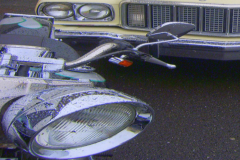

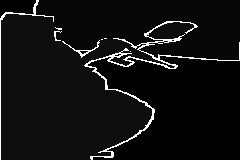

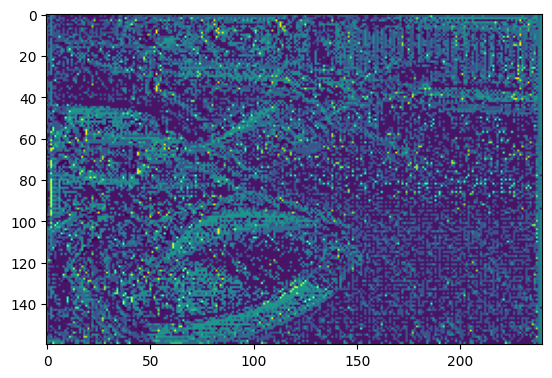

3.012229560495733

In [9]:
test()

In [10]:
model.train()

epoch_loss = []
for e in range(epoch):
    losses = []
    train_loop = tqdm(train_dl, desc=f'Epoch {e+1}/{epoch}', leave=False)
    for batch in train_loop:
        img, mask = batch
        img = img.to(DEVICE)
        mask = torch.from_numpy(np.array(mask)).long().to(DEVICE)
        
        logits = model(img)
        loss = loss_fn(logits, mask)
        losses.append(loss.item())
        train_loop.set_postfix({'loss': loss.item()})
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    if (e + 1) % 10 == 0:
        model.eval()
        test_loss = test()
        print('=' * 50)
        print(f'Epoch {e+1}/{epoch}: test loss: {test_loss}')
        print('=' * 50)
        model.train()
    epoch_loss.append(np.mean(losses))

model.eval()
test_loss = test()
print('=' * 50)
print(f'Epoch {e+1}/{epoch}: test loss: {test_loss}')
print('=' * 50)

print('Training ends. Saving model...')
torch.save(model.state_dict(), 'unet.ckpt')

x = np.linspace(1, epoch, epoch)
plt.plot(x, epoch_loss)

KeyboardInterrupt: 